In [0]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

transform = transforms.Compose([
                                transforms.ToTensor()
                                ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [0]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [0]:
BATCH_SIZE = 64
NOISE_DIMENSION = 784 # same as the input image

# random input
def sample_random_noise(batch_size, dim):
    return 2 * torch.rand((batch_size, dim), device=device) - 1

In [0]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 20),
            nn.ReLU(),
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.reshape(-1, 784)
        return self.model(x)

In [0]:
def get_optimizer(model):
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return optimizer

In [0]:
ED = EncoderDecoder().cuda() if USE_GPU and torch.cuda.is_available() else EncoderDecoder()

solver = get_optimizer(ED)


In [0]:
def run_encoder_decoder(model, solver, epochs):
    loss_list=[]
    loss = nn.BCELoss()
    data_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        total_instances=0
        for x, _ in data_loader:
            
            x = x.to(device)
            
            noise = sample_random_noise(x.shape[0], NOISE_DIMENSION).reshape(x.shape[0], 1, 28, 28)
            
            x_noise = x.add(noise)
            
            solver.zero_grad()
            output = model(x_noise)

            batch_loss = loss(output, x.reshape(-1, NOISE_DIMENSION))
            batch_loss.backward()
            solver.step()
            total_loss += batch_loss
            total_instances += x.shape[0]

        # Append the losses to the list
        loss_list.append(total_loss/total_instances)
            
    return loss_list

In [0]:
loss_list = run_encoder_decoder(ED, solver, 10)

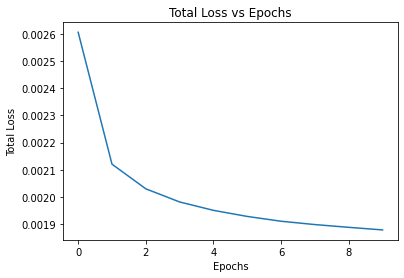

In [0]:
plt.plot(loss_list)
plt.title("Total Loss vs Epochs")
plt.ylabel("Total Loss")
plt.xlabel("Epochs")
plt.show()

In [0]:
test_data_loader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)

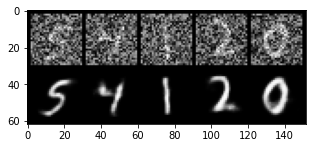

In [0]:
import torchvision.utils as vutils
for images, _ in test_data_loader:
    images = images.to(device)
    noise = sample_random_noise(images.shape[0], NOISE_DIMENSION).reshape(images.shape[0], 1, 28, 28)
    images_noise = images.add(noise)
    images_ed = ED(images_noise).reshape(5, 1, 28, 28)
    horizontal_grid = vutils.make_grid(torch.cat((images_noise, images_ed), 0), normalize=True, scale_each=True,nrow=5)
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(np.moveaxis(horizontal_grid.detach().cpu().numpy(), 0, -1))
    break

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
torch.save(ED, '/content/gdrive/My Drive/hw5_dAE.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type EncoderDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
